# Dataset

- id: Film için benzersiz tanımlayıcı numara
- imdb_id: IMDb (Internet Movie Database) veritabanındaki film için benzersiz tanımlayıcı
- popularity: Film popularitesini temsil eden bir sayısal değer
- revenue: Film geliri (dolar cinsinden)
- cast: Filmin oyuncu kadrosu
- homepage: Filmin resmi web sitesinin URL'si
- director: Filmin yönetmeni
- tagline: Filmin tanıtıcı bir cümlesi
- keywords: Filmle ilişkilendirilen anahtar kelimeler
- overview: Film hakkında genel bir açıklama
- runtime: Film süresi (dakika cinsinden)
- genres: Film türleri.
- production_companies: Film yapımcı şirket(ler)i
- release_date: Film çıkış tarihi.
- vote_count: Film için yapılan toplam oy sayısı
- vote_average: Film için ortalama oy puanı
- release_year: Film çıkış yılı
- budget_adj: Film bütçesi (dolar cinsinden, enflasyonu düzeltilmiş)
- revenue_adj: Film geliri (dolar cinsinden, enflasyonu düzeltilmiş)

## Exploratory Data Analysis (EDA)

In [45]:
# Import required libraries
import pandas as pd 
import numpy as np 
import string
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('movies_data.csv')


In [3]:
# Show initial information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [4]:
df.drop(['imdb_id', 'homepage', 'tagline', 'keywords','production_companies' ,'budget_adj', 'revenue_adj'], axis = 1, inplace=True)

In [5]:
# Finding Missing values in all columns
miss = pd.DataFrame(df.isnull().sum())
miss = miss.rename(columns={0: "miss_count"})
miss["miss_%"] = (miss.miss_count / len(df.id)) * 100
miss

,miss_count,miss_%
id,0,0.000000
popularity,0,0.000000
budget,0,0.000000
revenue,0,0.000000
original_title,0,0.000000
cast,76,0.699429
director,44,0.404933
overview,4,0.036812
runtime,0,0.000000
genres,23,0.211669


In [6]:
# Dropping Na's from the following columns
df.dropna(subset=['director','genres', 'cast', 'overview'],inplace=True)
df.reset_index(inplace=True,drop=True)

# Duplicate data delete
print(df.duplicated().sum())
df.drop_duplicates(inplace= True)
print(df.duplicated().sum())


1


0


In [7]:
df.isna().sum()

id                0
popularity        0
budget            0
revenue           0
original_title    0
cast              0
director          0
overview          0
runtime           0
genres            0
release_date      0
vote_count        0
vote_average      0
release_year      0
dtype: int64

In [8]:
df.head(3)

,id,popularity,budget,revenue,original_title,cast,director,overview,runtime,genres,release_date,vote_count,vote_average,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,6/9/2015,5562,6.5,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,5/13/2015,6185,7.1,2015
2,262500,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,3/18/2015,2480,6.3,2015


In [9]:
df['overview'][0]

'Twenty-two years after the events of Jurassic Park, Isla Nublar now features a fully functioning dinosaur theme park, Jurassic World, as originally envisioned by John Hammond.'

In [10]:
# Split the 'genres' column by "|" and expand into new columns
df_genres = df['genres'].str.split('|', expand=True)

# Create new columns 'genres1', 'genres2', and 'genres3' to store the first three genres
df['genres1'] = df_genres[0]
df['genres2'] = df_genres[1]
df['genres3'] = df_genres[2]

# Drop the original 'genres' column
#df.drop(['genres'], axis=1, inplace=True)


In [11]:
df.describe().style.background_gradient(cmap="Blues")

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year
count,10729.000000,10729.000000,10729.000000,10729.000000,10729.000000,10729.000000,10729.000000,10729.000000
mean,65200.451673,0.652693,14806405.701557,40327403.644981,102.478609,219.851151,5.964899,2001.257806
std,91478.789145,1.004881,31066793.825142,117662099.143860,30.480653,578.862518,0.930260,12.820656
min,5.000000,0.000188,0.000000,0.000000,0.000000,10.000000,1.500000,1960.000000
25%,10547.000000,0.210766,0.000000,0.000000,90.000000,17.000000,5.400000,1995.000000
50%,20312.000000,0.387190,0.000000,0.000000,99.000000,39.000000,6.000000,2006.000000
75%,73939.000000,0.721427,16000000.000000,25000000.000000,112.000000,148.000000,6.600000,2011.000000
max,417859.000000,32.985763,425000000.000000,2781505847.000000,900.000000,9767.000000,9.200000,2015.000000


# Visualization

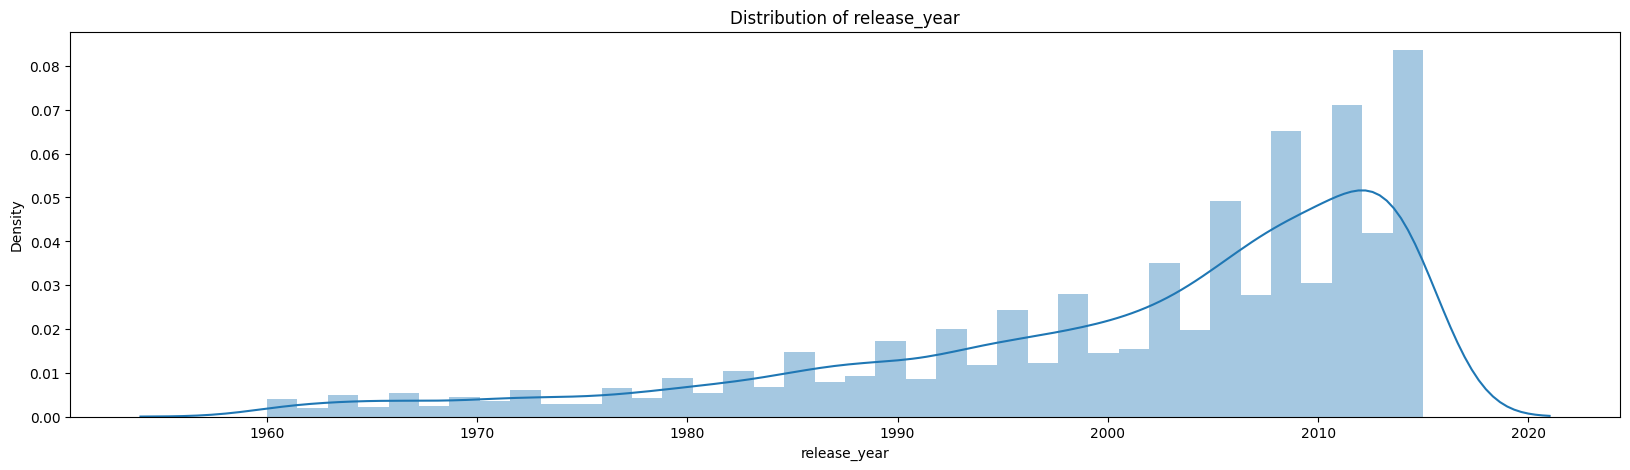

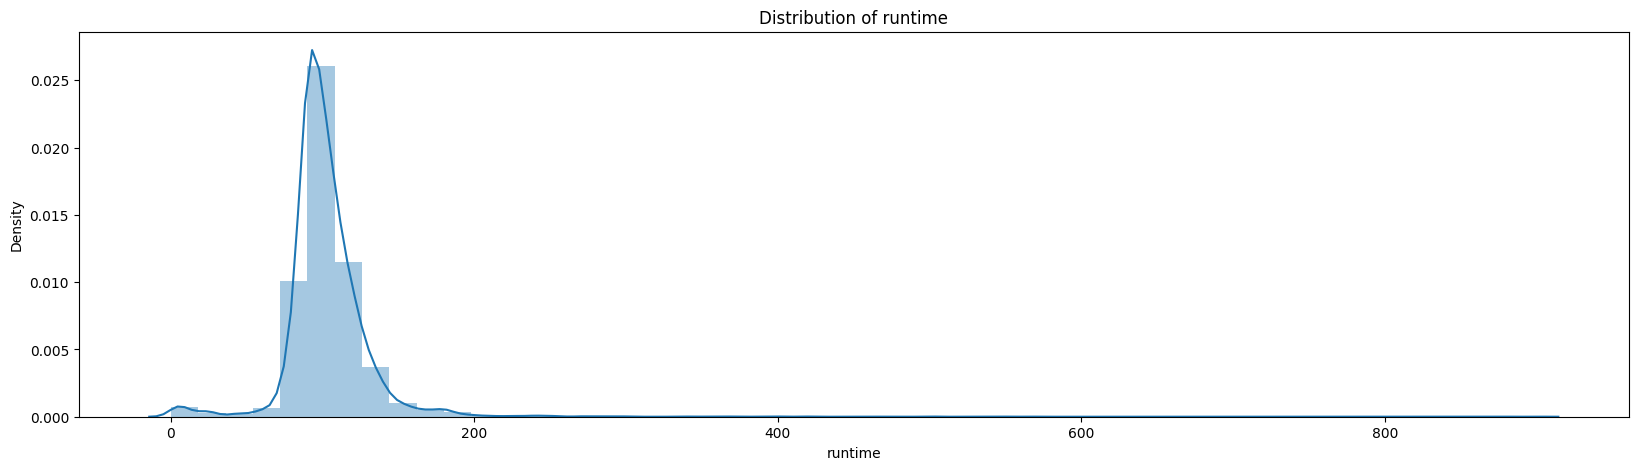

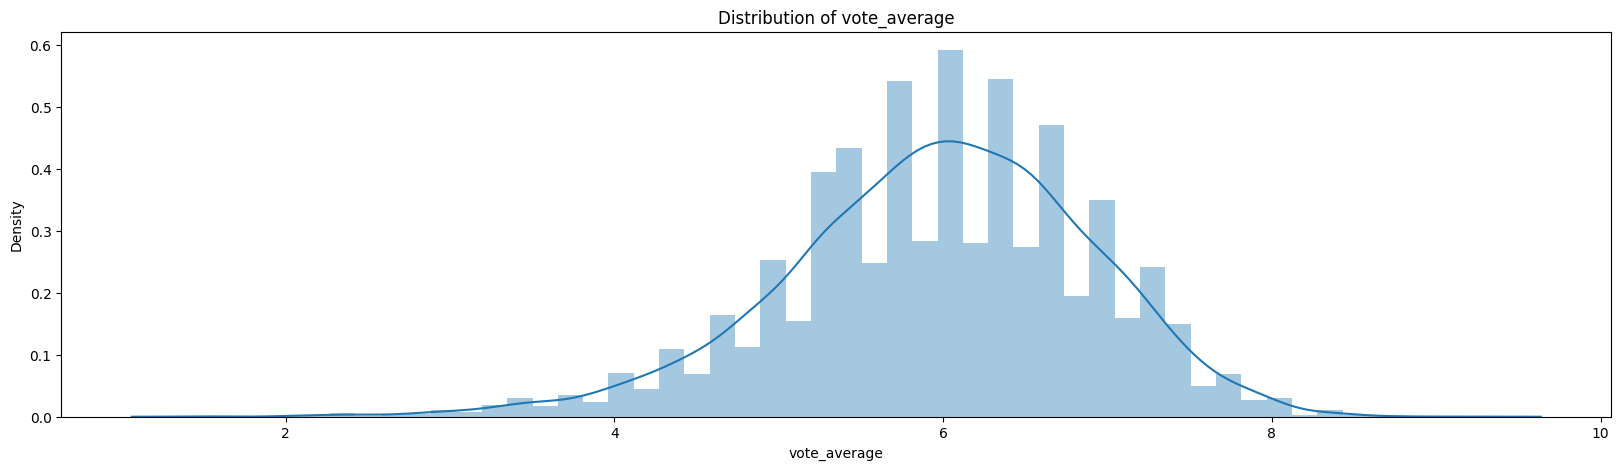

In [12]:
def plot_distribution(data, column, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    sns.distplot(data[column])
    plt.title(f'Distribution of {column}')
    plt.show()

plot_distribution(df, 'release_year')
plot_distribution(df, 'runtime')
plot_distribution(df, 'vote_average')

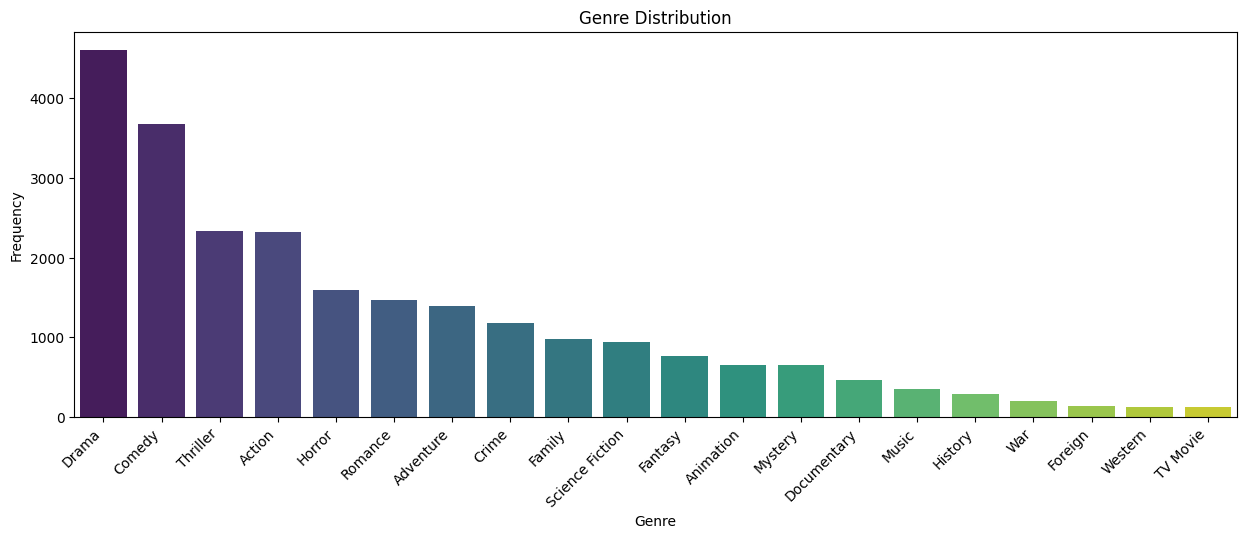

In [60]:
def plot_genre_distribution(data, genre_columns, figsize=(15, 5)):

    all_genres = data[genre_columns].values.flatten()
    all_genres = [genre for genre in all_genres if genre is not None]
    genre_counts = pd.Series(all_genres).value_counts()

   
    plt.figure(figsize=figsize)
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
    plt.title('Genre Distribution')
    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  
    plt.show()
    
plot_genre_distribution(df, ['genres1', 'genres2', 'genres3']) 

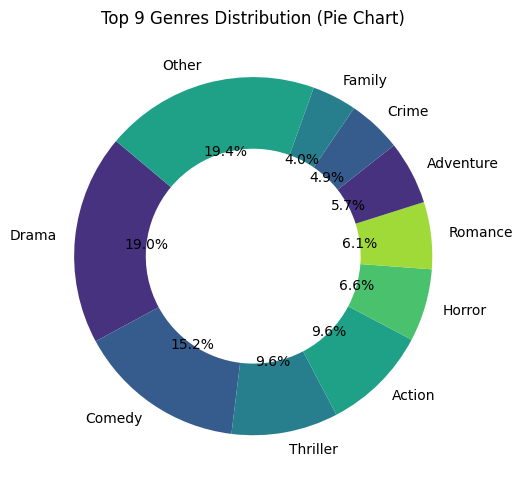

In [63]:
def genre_pie(data, genre_columns, figsize=(15, 5)):
    all_genres = data[genre_columns].values.flatten()
    all_genres = [genre for genre in all_genres if genre is not None]
    genre_counts = pd.Series(all_genres).value_counts()

    # Top 9 genres
    top_genres = genre_counts.head(9)
    # Sum of remaining genres
    other_genres_count = genre_counts.iloc[9:].sum()

    # Append 'Other' category to top_genres
    top_genres['Other'] = other_genres_count
    
    # Pie chart
    plt.figure(figsize=figsize)
    plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'), wedgeprops=dict(width=0.4))
    plt.title('Top 9 Genres Distribution (Pie Chart)')

    plt.tight_layout()
    plt.show()

# Örnek Kullanım
genre_pie(df, ['genres1', 'genres2', 'genres3'])


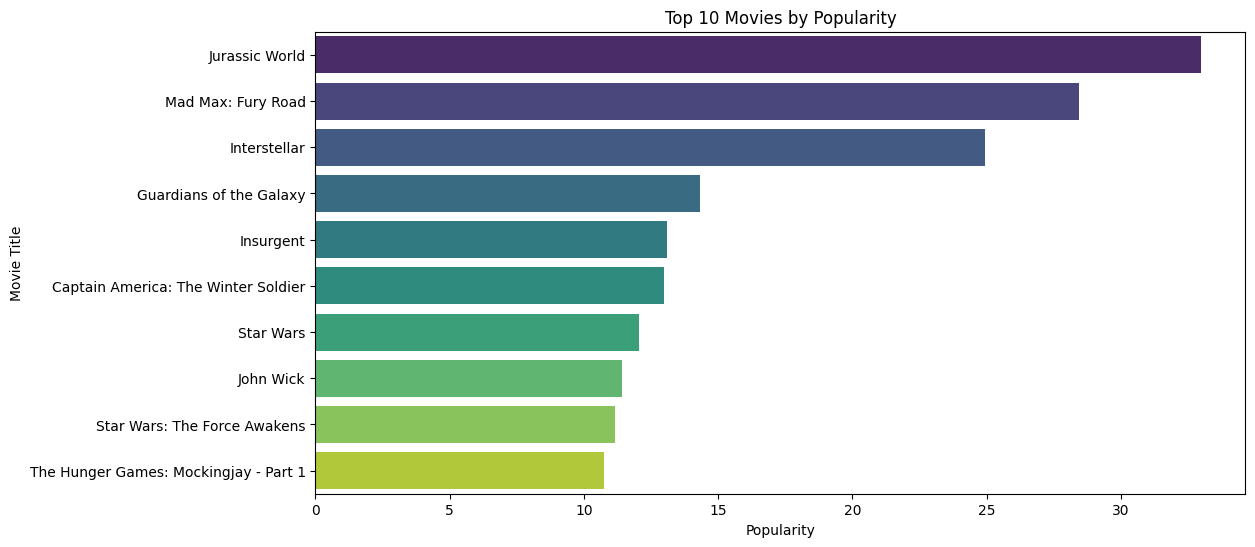

In [14]:
top_10_popular_movies = df.sort_values(by='popularity', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='popularity', y='original_title', data=top_10_popular_movies, palette='viridis')
plt.title('Top 10 Movies by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Movie Title')
plt.show()

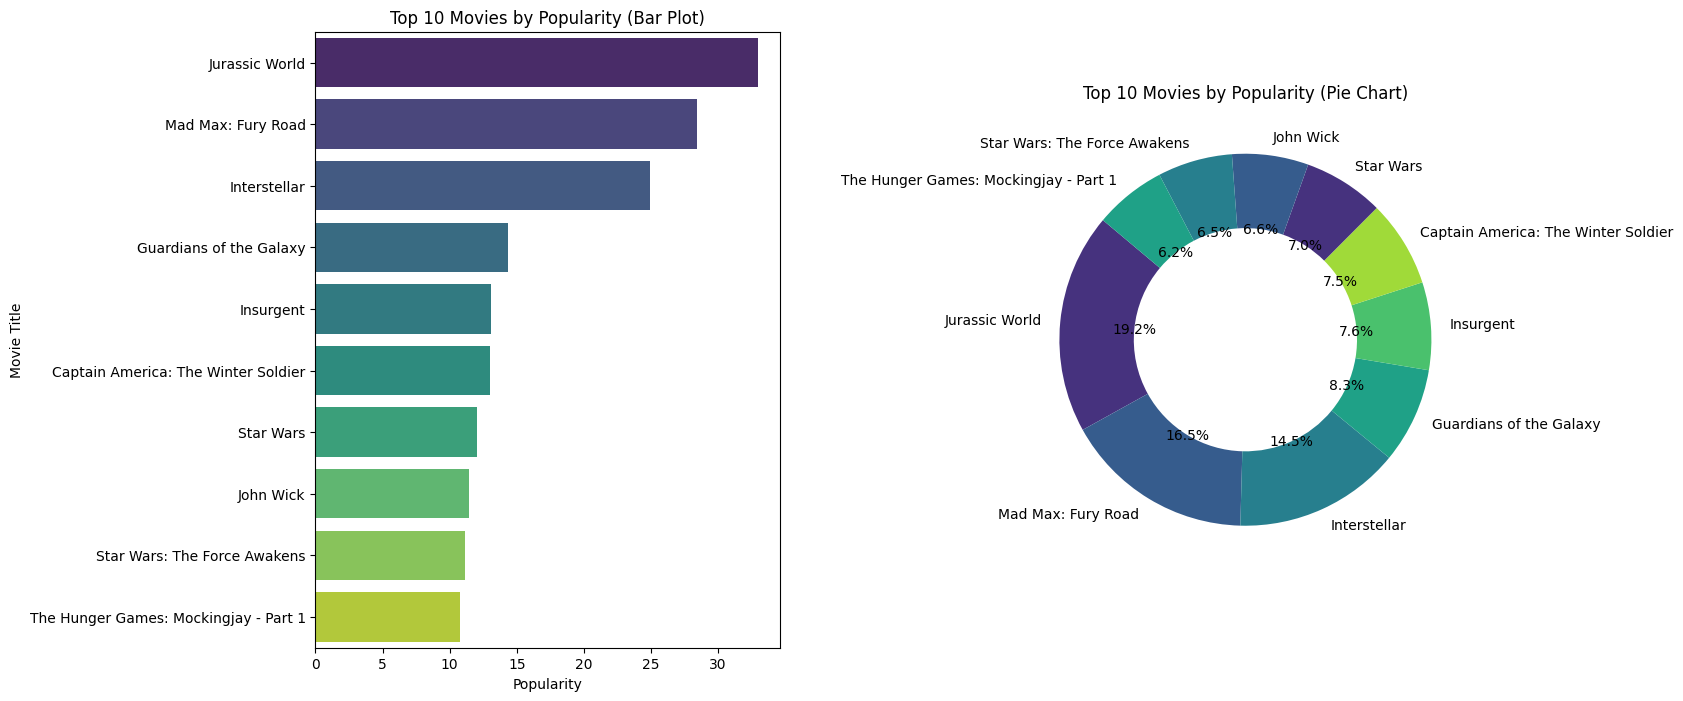

In [15]:
def plot_top_movies_distribution(top_movies, figsize=(15, 8)):
    plt.figure(figsize=figsize)

    # Bar plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='popularity', y='original_title', data=top_movies, palette='viridis')
    plt.title('Top 10 Movies by Popularity (Bar Plot)')
    plt.xlabel('Popularity')
    plt.ylabel('Movie Title')

    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(top_movies['popularity'], labels=top_movies['original_title'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'), wedgeprops=dict(width=0.4))
    plt.title('Top 10 Movies by Popularity (Pie Chart)')

    # Adjust space between subplots
    plt.subplots_adjust(wspace=0.5)

    plt.show()

# Örnek Kullanım
plot_top_movies_distribution(top_10_popular_movies)


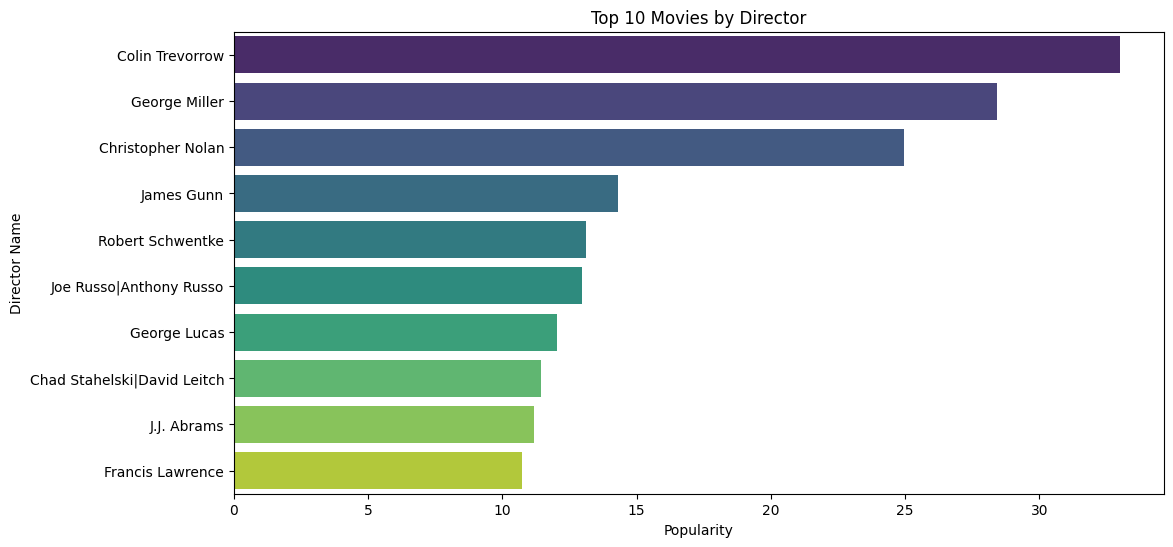

In [16]:
top_10_popular_director = df.sort_values(by='director', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='popularity', y='director', data=top_10_popular_movies, palette='viridis')
plt.title('Top 10 Movies by Director')
plt.xlabel('Popularity')
plt.ylabel('Director Name')
plt.show()

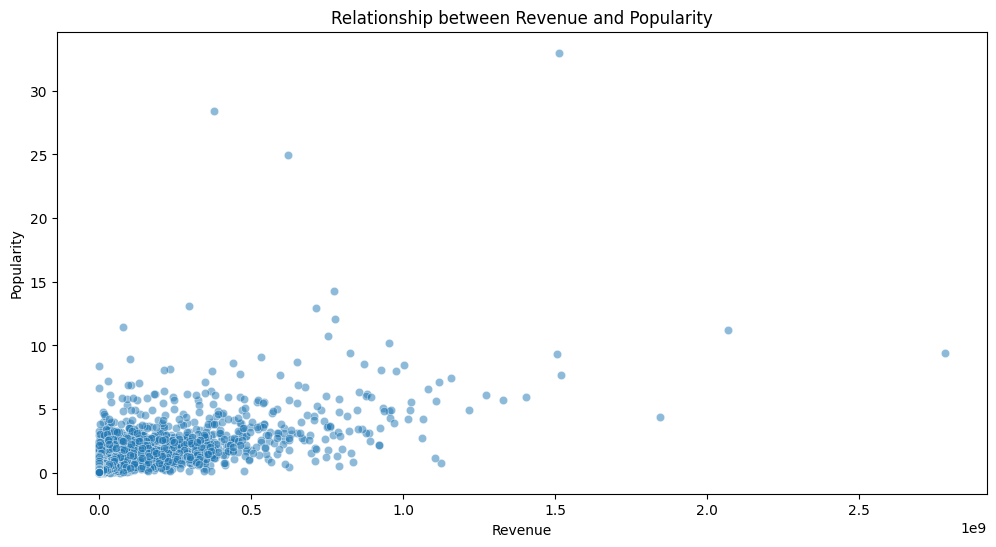

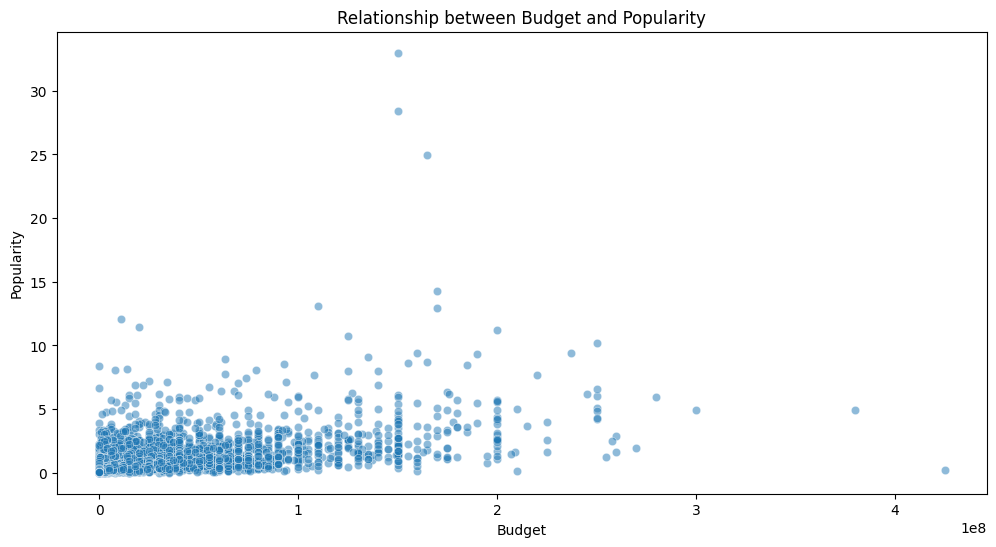

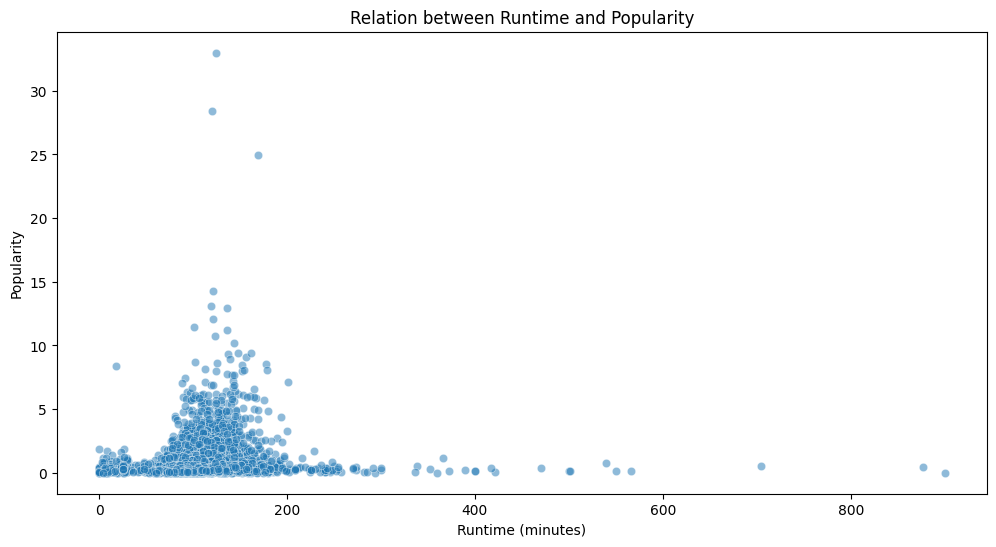

In [17]:
def create_scatter_plot(x, y, data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    scatter_plot = sns.scatterplot(x=x, y=y, data=data, alpha=0.5, palette='viridis')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


create_scatter_plot('revenue', 'popularity', df, 'Relationship between Revenue and Popularity', 'Revenue', 'Popularity')
create_scatter_plot('budget', 'popularity', df, 'Relationship between Budget and Popularity', 'Budget', 'Popularity')
create_scatter_plot('runtime', 'popularity', df, 'Relation between Runtime and Popularity', 'Runtime (minutes)', 'Popularity')

 ## Building a Recommender System

- Content Based Filtering (İçerik Temelli Filtreleme)

In [18]:
df2 = df[['id','original_title', 'cast', 'director', 'overview', 'genres']]
df2.head(3)

,id,original_title,cast,director,overview,genres
0,135397,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,Action|Adventure|Science Fiction|Thriller
1,76341,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,An apocalyptic story set in the furthest reach...,Action|Adventure|Science Fiction|Thriller
2,262500,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,Beatrice Prior must confront her inner demons ...,Adventure|Science Fiction|Thriller


In [19]:
df2['cast'] = df2['cast'].apply(lambda x: x.replace("|", ","))
df2['genres'] = df2['genres'].apply(lambda x: x.replace("|", ","))

In [20]:
# lowercase
def lowercase_conversion(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda x: " ".join(x.lower() for x in x.split()))
    return data

df2 = lowercase_conversion(df2, ['cast', 'director', 'overview', 'genres'])

In [21]:
def remove_spaces(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda x: " ".join(x.split()))
    return data
df2 = remove_spaces(df2, ['cast', 'director', 'overview'])

In [22]:
def remove_numbers(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda x: re.sub(r'\d+', '', x))
    return data

df2 = remove_numbers(df2, ['cast', 'director', 'overview'])

In [23]:
sw = set(stopwords.words("english"))
print(sw)
df2['overview'] = df2['overview'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))

{"should've", 'the', 'further', 'he', 'are', 'have', 'can', 'in', 'shouldn', 'on', 'does', "you'd", 'while', 'her', 'than', 'from', 'should', 'mightn', 'after', "don't", 'ain', 'whom', 'him', 'which', 'his', "needn't", 'because', 'haven', "mustn't", "mightn't", "she's", 'being', 'doesn', 'did', 'more', 'they', "wouldn't", 'couldn', 'was', 'then', 'hers', 'only', 'each', 'with', 'about', 'until', 'i', 'under', 'ourselves', 'such', 'its', 'all', 'here', "haven't", 'wasn', 'or', 'been', 'over', "you've", 'for', 'were', 'below', 'has', 'hasn', 'himself', "aren't", 's', 'through', 'up', 'hadn', 'once', 'any', 'ma', 'be', 'your', 'm', 'shan', 'doing', 'during', 'had', 'just', 'd', 'is', 'very', 'nor', 't', 'wouldn', 'and', 'against', 'mustn', 'down', 'aren', 'above', 'don', 'at', "won't", 'both', "weren't", 'an', 'themselves', 'no', 'few', 'yourselves', 'too', 'there', "hasn't", 'you', 'll', "wasn't", 'weren', "isn't", 'if', 'but', "shouldn't", 'itself', 'that', 'as', 'it', 'having', 'again'

In [24]:
df2.head(3)

,id,original_title,cast,director,overview,genres
0,135397,Jurassic World,"chris pratt,bryce dallas howard,irrfan khan,vi...",colin trevorrow,twentytwo years after the events of jurassic p...,"action,adventure,science fiction,thriller"
1,76341,Mad Max: Fury Road,"tom hardy,charlize theron,hugh keays-byrne,nic...",george miller,an apocalyptic story set in the furthest reach...,"action,adventure,science fiction,thriller"
2,262500,Insurgent,"shailene woodley,theo james,kate winslet,ansel...",robert schwentke,beatrice prior must confront her inner demons ...,"adventure,science fiction,thriller"


In [25]:
df2["overview_cleaned"] = df2.overview.str.split(" ")
df2.overview_cleaned = df2.overview_cleaned.apply(lambda x: [i for i in x if i not in sw])

In [26]:
df2[['overview','overview_cleaned']]

,overview,overview_cleaned
0,twentytwo years after the events of jurassic p...,"[twentytwo, years, events, jurassic, park, isl..."
1,an apocalyptic story set in the furthest reach...,"[apocalyptic, story, set, furthest, reaches, p..."
2,beatrice prior must confront her inner demons ...,"[beatrice, prior, must, confront, inner, demon..."
3,thirty years after defeating the galactic empi...,"[thirty, years, defeating, galactic, empire, h..."
4,deckard shaw seeks revenge against dominic tor...,"[deckard, shaw, seeks, revenge, dominic, toret..."
...,...,...
10725,the endless summer by bruce brown is one of th...,"[endless, summer, bruce, brown, one, first, in..."
10726,grand prix driver pete aron is fired by his te...,"[grand, prix, driver, pete, aron, fired, team,..."
10727,an insurance agent who moonlights as a carthie...,"[insurance, agent, moonlights, carthief, steal..."
10728,in comic woody allens film debut he took the j...,"[comic, woody, allens, film, debut, took, japa..."


In [28]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """POS tagger kullanarak kelime türünü belirleme"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    """Verilen metni lemmatize ederek geri döndürme"""
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text
df2['overview_cleaned'] = df2['overview_cleaned'].apply(lambda x: lemmatize_text(' '.join(x)))

In [40]:
df2.head(3)

,id,original_title,cast,director,overview,genres,overview_cleaned
0,135397,Jurassic World,"chris pratt,bryce dallas howard,irrfan khan,vi...",colin trevorrow,twentytwo years after the events of jurassic p...,"action,adventure,science fiction,thriller",twentytwo year event jurassic park isla nublar...
1,76341,Mad Max: Fury Road,"tom hardy,charlize theron,hugh keays-byrne,nic...",george miller,an apocalyptic story set in the furthest reach...,"action,adventure,science fiction,thriller",apocalyptic story set furthest reach planet st...
2,262500,Insurgent,"shailene woodley,theo james,kate winslet,ansel...",robert schwentke,beatrice prior must confront her inner demons ...,"adventure,science fiction,thriller",beatrice prior must confront inner demon conti...


In [46]:
tfidf = TfidfVectorizer(max_features=10000)

tfidf_cast = tfidf.fit_transform(df2['cast']).toarray()
sim_cast = cosine_similarity(tfidf_cast)

tfidf_director = tfidf.fit_transform(df2['director']).toarray()
sim_director = cosine_similarity(tfidf_director)

tfidf_genres = tfidf.fit_transform(df2['genres']).toarray()
sim_genres = cosine_similarity(tfidf_genres)

tfidf_overview_cleaned = tfidf.fit_transform(df2['overview_cleaned']).toarray()
simi_overview_cleaned = cosine_similarity(tfidf_overview_cleaned)

In [49]:
tfidf_genres[1]

array([0.39308192, 0.46885441, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.49739618,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.49739618, 0.36174054, 0.        ,
       0.        , 0.        ])

In [50]:
def recommend_movie(movie_name, similarity_matrix):
    movie_index = df2[df2['original_title'] == movie_name].index[0]
    similarity_array = similarity_matrix[movie_index]
    similar_movies = sorted(list(enumerate(similarity_array)), reverse=True, key=lambda x: x[1])[1:11]
    for i in similar_movies:
        print(df2.iloc[i[0]]['original_title'])

In [54]:
recommend_movie("Jurassic World", sim_genres)

Mad Max: Fury Road
Terminator Genisys
Vice
Halo: Nightfall
G.I. Joe: The Rise of Cobra
Universal Soldier: Regeneration
Street Fighter: The Legend of Chun-Li
X-Men Origins: Wolverine
Hardwired
Predators


- Collaborating Filtering (İş Birlikçi Filtreleme)

- Association Rule Learning (Birliktelik Kuralı Öğrenimi)